<a href="https://colab.research.google.com/github/Kaustubh1235/BIO-SMALL-LANGUAGE-MODEL/blob/main/BIO_SLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Pre-training

### 1.1 Loading the dataset

In [ ]:
# Colab: Download ~10 GB (uncompressed) of PubMed baseline XML
import os, re, subprocess, math, requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin


In [ ]:
BASE_URL = "https://ftp.ncbi.nlm.nih.gov/pubmed/baseline/"
TARGET_UNCOMPRESSED_GB = 10.0
DEST = "/content/pubmed_xml_subset"
os.makedirs(DEST, exist_ok=True)

In [ ]:
# 1) Fetch list of .gz files from the baseline index
html = requests.get(BASE_URL, timeout=60).text
soup = BeautifulSoup(html, "html.parser")

# All .gz files (e.g., pubmed24n0001.xml.gz)
hrefs = [a.get("href") for a in soup.find_all("a", href=True)]
gz_files = sorted([h for h in hrefs if h.endswith(".gz")])

print(f"Found {len(gz_files)} .gz files on the baseline index.")

Found 1274 .gz files on the baseline index.


In [ ]:

# 2) Download sequentially until uncompressed total ≈ target
def gz_uncompressed_bytes(local_path):
    # Use gzip -l to read uncompressed size from footer (fast; no full decompress)
    out = subprocess.check_output(["gzip", "-l", local_path]).decode()
    # The second line has: compressed  uncompressed  ratio  uncompressed_name
    lines = out.strip().splitlines()
    if len(lines) >= 2:
        parts = re.split(r"\s+", lines[1].strip())
        # parts[1] = uncompressed bytes
        return int(parts[1])
    return 0

total_uncompressed = 0
downloaded = []

for fname in gz_files:
    url = urljoin(BASE_URL, fname)
    local = os.path.join(DEST, fname)
    if not os.path.exists(local):
        print(f"→ downloading {fname} ...")
        # quiet, continue on partial, retry a bit
        ret = subprocess.call(["wget", "-q", "-c", "-O", local, url])
        if ret != 0:
            print(f"  ! failed: {fname}; skipping")
            if os.path.exists(local): os.remove(local)
            continue
    # read uncompressed size
    try:
        ub = gz_uncompressed_bytes(local)
        total_uncompressed += ub
        downloaded.append((fname, ub))
        print(f"  added {fname}: {ub/1e9:.3f} GB uncompressed  |  total ≈ {total_uncompressed/1e9:.3f} GB")
    except Exception as e:
        print(f"  ! could not read size for {fname}: {e}")

    if total_uncompressed >= TARGET_UNCOMPRESSED_GB * 1e9:
        print("\nTarget reached. Stopping downloads.")
        break

print(f"\nDone. Saved {len(downloaded)} files to: {DEST}")
print(f"Approx. uncompressed total: {total_uncompressed/1e9:.3f} GB")

→ downloading pubmed25n0001.xml.gz ...
  added pubmed25n0001.xml.gz: 0.196 GB uncompressed  |  total ≈ 0.196 GB
→ downloading pubmed25n0002.xml.gz ...
  added pubmed25n0002.xml.gz: 0.183 GB uncompressed  |  total ≈ 0.378 GB
→ downloading pubmed25n0003.xml.gz ...
  added pubmed25n0003.xml.gz: 0.175 GB uncompressed  |  total ≈ 0.553 GB
→ downloading pubmed25n0004.xml.gz ...
  added pubmed25n0004.xml.gz: 0.183 GB uncompressed  |  total ≈ 0.736 GB
→ downloading pubmed25n0005.xml.gz ...
  added pubmed25n0005.xml.gz: 0.175 GB uncompressed  |  total ≈ 0.911 GB
→ downloading pubmed25n0006.xml.gz ...
  added pubmed25n0006.xml.gz: 0.201 GB uncompressed  |  total ≈ 1.113 GB
→ downloading pubmed25n0007.xml.gz ...
  added pubmed25n0007.xml.gz: 0.204 GB uncompressed  |  total ≈ 1.316 GB
→ downloading pubmed25n0008.xml.gz ...
  added pubmed25n0008.xml.gz: 0.199 GB uncompressed  |  total ≈ 1.515 GB
→ downloading pubmed25n0009.xml.gz ...
  added pubmed25n0009.xml.gz: 0.127 GB uncompressed  |  total ≈ 1

### 1.2 Converting title and abstract from XML to TXT

In [ ]:
# Colab cell: Parse title + abstract to plain text (one doc/line)
import os, gzip, glob
from lxml import etree
from tqdm import tqdm

SRC_DIR = "/content/pubmed_xml_subset"         # where your .xml.gz files are
OUT_DIR = "/content/pubmed_txt"                # output folder
os.makedirs(OUT_DIR, exist_ok=True)

train_path = f"{OUT_DIR}/train.txt"
valid_path = f"{OUT_DIR}/valid.txt"
test_path  = f"{OUT_DIR}/test.txt"

# ----- helper: stream-parse one PubMed file -----
def yield_title_abstract(fp):
    # iterparse to avoid loading whole XML into RAM
    ctx = etree.iterparse(gzip.open(fp), events=("end",), tag="PubmedArticle")
    for _, elem in ctx:
        # Title
        t = elem.find(".//ArticleTitle")
        title = (t.text or "").strip() if t is not None else ""
        # Abstract may have multiple parts <AbstractText>
        abs_nodes = elem.findall(".//AbstractText")
        abs_parts = []
        for a in abs_nodes:
            txt = (a.text or "").strip()
            if txt:
                abs_parts.append(txt)
        abstract = " ".join(abs_parts).strip()

        if title and abstract:
            text = f"{title}. {abstract}"
            # clean newlines/tabs
            text = " ".join(text.split())
            yield text

        # free memory
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
    del ctx

# ----- collect and write -----
gz_files = sorted(glob.glob(os.path.join(SRC_DIR, "*.xml.gz")))
print(f"Found {len(gz_files)} gz files")

# We'll stream all docs, then do a simple split by count.
all_out = f"{OUT_DIR}/_all.txt"
with open(all_out, "w", encoding="utf-8") as out:
    for fp in tqdm(gz_files, desc="Parsing"):
        for line in yield_title_abstract(fp):
            out.write(line + "\n")

# Quick stats
num_lines = sum(1 for _ in open(all_out, "r", encoding="utf-8"))
print("Total docs with title+abstract:", num_lines)

# Split 98% / 1% / 1% (adjust if you like)
train_n = int(num_lines * 0.98)
valid_n = int(num_lines * 0.01)
test_n  = num_lines - train_n - valid_n

with open(all_out, "r", encoding="utf-8") as fin, \
     open(train_path, "w", encoding="utf-8") as ftr, \
     open(valid_path, "w", encoding="utf-8") as fva, \
     open(test_path,  "w", encoding="utf-8") as fte:
    for i, line in enumerate(fin):
        if i < train_n: ftr.write(line)
        elif i < train_n + valid_n: fva.write(line)
        else: fte.write(line)

print("Wrote:")
print(" ", train_path)
print(" ", valid_path)
print(" ", test_path)


Found 56 gz files


Parsing: 100%|██████████| 56/56 [04:41<00:00,  5.03s/it]


Total docs with title+abstract: 846402
Wrote:
  /content/pubmed_txt/train.txt
  /content/pubmed_txt/valid.txt
  /content/pubmed_txt/test.txt


In [ ]:
# Colab cell: Install tools
!pip -q install sacremoses==0.0.53
!sudo apt-get -y install g++ >/dev/null

# fastBPE (build once)
!git clone -q https://github.com/glample/fastBPE.git /content/fastBPE
%cd /content/fastBPE
!g++ -std=c++11 -O3 -pthread fastBPE/main.cc -IfastBPE -o fast
%cd /content

# fairseq (0.12.0 recommended for GPT2-medium arch flag)
!git clone -q https://github.com/pytorch/fairseq.git /content/fairseq
%cd /content/fairseq
!git checkout v0.12.0 -q
!pip -q install .
%cd /content


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
/content/fastBPE
/content
/content/fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Requested omegaconf<2.1 from https://files.pythonhosted.org/packages/d0/eb/9d63ce09dd8aa85767c65668d5414958ea29648a0eec80a4a7d311ec2684/omegaconf-2.0.6-py3-none-any.whl (from fairseq==0.12.0) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    PyYAML (>=5.1.*)
            ~~~~~~^
Please use pip<24.1 if you need to use this version.
Requested omegaconf<2.1 from https://files.pythonhosted.org/packages/e5/f6/043b6d255dd6fbf2025110cea35b87f4c5100a181681d8eab496269f0d5b/omegaconf-2.0.5-py3-none-any.whl (from fairseq==0.12.0) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    PyYAML (>=5.1.*)
    

### 1.3 Fetch the BioGPT Vocabulary and merged tokens

In [ ]:
# Colab cell: Grab BioGPT bpecodes/dict
!wget -q -O /content/bpecodes https://raw.githubusercontent.com/microsoft/BioGPT/main/data/BioGPT/bpecodes
!wget -q -O /content/dict.txt  https://raw.githubusercontent.com/microsoft/BioGPT/main/data/BioGPT/dict.txt
!wc -l /content/dict.txt && head -n 5 /content/dict.txt


42380 /content/dict.txt
. 142442146
of 136351517
the 133562497
, 127378192
and 105334276


### 1.4 Use Moses tokenizer to clean text before applying BPE

In [ ]:
import os
from sacremoses import MosesTokenizer
from tqdm.auto import tqdm

TXT_DIR = "/content/pubmed_txt"
BPE_DIR = "/content/pubmed_bpe"
os.makedirs(BPE_DIR, exist_ok=True)

mt = MosesTokenizer(lang="en")

def tokenize_file(in_path, out_path, show_progress=True):
    # Count lines once for a nice total
    with open(in_path, "r", encoding="utf-8") as f:
        total = sum(1 for _ in f)

    with open(in_path, "r", encoding="utf-8") as fin, \
         open(out_path, "w", encoding="utf-8") as fout:
        iterator = fin
        if show_progress:
            iterator = tqdm(fin, total=total, desc=f"Tokenizing {os.path.basename(in_path)}")
        for line in iterator:
            line = line.strip()
            if not line:
                continue
            fout.write(mt.tokenize(line, return_str=True) + "\n")

for split in ["train", "valid", "test"]:
    tok = f"{BPE_DIR}/{split}.tok"
    bpe = f"{BPE_DIR}/{split}.bpe"
    tokenize_file(f"{TXT_DIR}/{split}.txt", tok)


Tokenizing train.txt:   0%|          | 0/829473 [00:00<?, ?it/s]

Tokenizing valid.txt:   0%|          | 0/8464 [00:00<?, ?it/s]

Tokenizing test.txt:   0%|          | 0/8465 [00:00<?, ?it/s]

### 1.5 Apply BPE to dataset

In [ ]:
import os, math, subprocess, numpy as np, shutil
from tqdm.auto import tqdm

BPE_CODES = "/content/bpecodes"     # BioGPT bpecodes
DICT_TXT  = "/content/dict.txt"     # BioGPT dict
BPE_DIR   = "/content/pubmed_bpe"   # where your .tok files are
BIN_DIR   = "/content/pubmed_memmap"
TMP_DIR   = "/content/_bpe_tmp"
os.makedirs(BIN_DIR, exist_ok=True)
os.makedirs(TMP_DIR, exist_ok=True)

# --- load vocab ---
token2id = {}
with open(DICT_TXT, encoding="utf-8") as f:
    for i, line in enumerate(f):
        tok = line.split()[0]
        token2id[tok] = i
# choose a fallback id ONLY IF we see OOVs later
fallback_id = token2id.get("</s>", next(iter(token2id.values())))  # prefer EOS, else first token

# --- ensure fastBPE binary exists ---
if not os.path.exists("/content/fastBPE/fast"):
    !git clone -q https://github.com/glample/fastBPE.git /content/fastBPE
    %cd /content/fastBPE
    !g++ -std=c++11 -O3 -pthread fastBPE/main.cc -IfastBPE -o fast
    %cd /content

def line_count(path):
    c = 0
    with open(path, encoding="utf-8") as f:
        for _ in f:
            c += 1
    return c

def apply_bpe_with_progress(tok_file, bpe_file, shards=50):
    total_lines = line_count(tok_file)
    if total_lines == 0:
        open(bpe_file, "w").close()
        return

    shards = max(1, min(shards, total_lines))
    lines_per = math.ceil(total_lines / shards)

    split_dir = os.path.join(TMP_DIR, "split")
    out_dir   = os.path.join(TMP_DIR, "bpe_parts")
    os.makedirs(split_dir, exist_ok=True)
    os.makedirs(out_dir, exist_ok=True)

    # 1) split with progress
    with open(tok_file, encoding="utf-8") as fin:
        shard_idx = 0
        line_idx  = 0
        fout = None
        pbar = tqdm(total=total_lines, desc=f"Splitting {os.path.basename(tok_file)}")
        for line in fin:
            if line_idx % lines_per == 0:
                if fout: fout.close()
                shard_idx += 1
                fout = open(os.path.join(split_dir, f"part_{shard_idx:05d}.tok"), "w", encoding="utf-8")
            fout.write(line)
            line_idx += 1
            pbar.update(1)
        if fout: fout.close()
        pbar.close()

    # 2) BPE on each shard with progress
    parts = sorted([p for p in os.listdir(split_dir) if p.endswith(".tok")])
    for p in tqdm(parts, desc="Applying BPE to shards"):
        src = os.path.join(split_dir, p)
        dst = os.path.join(out_dir, p.replace(".tok", ".bpe"))
        subprocess.check_call(["/content/fastBPE/fast", "applybpe", dst, src, BPE_CODES])

    # 3) concat with progress
    with open(bpe_file, "w", encoding="utf-8") as fout:
        for p in tqdm(parts, desc="Concatenating BPE shards"):
            src = os.path.join(out_dir, p.replace(".tok", ".bpe"))
            with open(src, encoding="utf-8") as fin:
                shutil.copyfileobj(fin, fout)

    shutil.rmtree(split_dir, ignore_errors=True)
    shutil.rmtree(out_dir,   ignore_errors=True)

def make_bin(split, dtype=np.uint16, shards=64):
    tok_file = os.path.join(BPE_DIR, f"{split}.tok")
    bpe_file = os.path.join(BPE_DIR, f"{split}.bpe")

    print(f"\n[{split}] Step 1: Applying BPE merges with progress...")
    apply_bpe_with_progress(tok_file, bpe_file, shards=shards)

    print(f"[{split}] Step 2: Counting total tokens...")
    total_tokens, total_lines = 0, 0
    with open(bpe_file, encoding="utf-8") as f:
        for line in tqdm(f, desc="Counting tokens"):
            total_tokens += len(line.strip().split())
            total_lines  += 1
    print(f"[{split}] Total tokens: {total_tokens:,} | lines: {total_lines:,}")

    print(f"[{split}] Step 3: Encoding to IDs & writing memmap...")
    bin_path = os.path.join(BIN_DIR, f"{split}.bin")
    arr = np.memmap(bin_path, dtype=dtype, mode="w+", shape=(total_tokens,))

    idx = 0
    oov_count = 0
    oov_samples = {}
    with open(bpe_file, encoding="utf-8") as f:
        for line in tqdm(f, total=total_lines, desc=f"Encoding {split}"):
            toks = line.strip().split()
            ids  = []
            for t in toks:
                if t in token2id:
                    ids.append(token2id[t])
                else:
                    oov_count += 1
                    if len(oov_samples) < 10:
                        oov_samples[t] = oov_samples.get(t, 0) + 1
                    ids.append(fallback_id)  # safe fallback if any OOVs occur
            n = len(ids)
            arr[idx:idx+n] = np.fromiter(ids, dtype=dtype, count=n)
            idx += n
    arr.flush()

    if oov_count == 0:
        print(f"[{split}] ✅ Saved {bin_path} (no OOVs)")
    else:
        print(f"[{split}] ⚠️ Saved {bin_path} with {oov_count} OOV tokens mapped to id {fallback_id}.")
        print("   First few OOV examples:", list(oov_samples.items()))

for split in ["train", "valid", "test"]:
    make_bin(split, dtype=np.uint16, shards=64)



[train] Step 1: Applying BPE merges with progress...


Splitting train.tok:   0%|          | 0/829473 [00:00<?, ?it/s]

Applying BPE to shards:   0%|          | 0/64 [00:00<?, ?it/s]

Concatenating BPE shards:   0%|          | 0/64 [00:00<?, ?it/s]

[train] Step 2: Counting total tokens...


Counting tokens: 0it [00:00, ?it/s]

[train] Total tokens: 163,985,120 | lines: 829,473
[train] Step 3: Encoding to IDs & writing memmap...


Encoding train:   0%|          | 0/829473 [00:00<?, ?it/s]

[train] ⚠️ Saved /content/pubmed_memmap/train.bin with 27 OOV tokens mapped to id 0.
   First few OOV examples: [('\x92', 8), ('\x96', 7), ('`@@', 12)]

[valid] Step 1: Applying BPE merges with progress...


Splitting valid.tok:   0%|          | 0/8464 [00:00<?, ?it/s]

Applying BPE to shards:   0%|          | 0/64 [00:00<?, ?it/s]

Concatenating BPE shards:   0%|          | 0/64 [00:00<?, ?it/s]

[valid] Step 2: Counting total tokens...


Counting tokens: 0it [00:00, ?it/s]

[valid] Total tokens: 2,085,616 | lines: 8,464
[valid] Step 3: Encoding to IDs & writing memmap...


Encoding valid:   0%|          | 0/8464 [00:00<?, ?it/s]

[valid] ✅ Saved /content/pubmed_memmap/valid.bin (no OOVs)

[test] Step 1: Applying BPE merges with progress...


Splitting test.tok:   0%|          | 0/8465 [00:00<?, ?it/s]

Applying BPE to shards:   0%|          | 0/64 [00:00<?, ?it/s]

Concatenating BPE shards:   0%|          | 0/64 [00:00<?, ?it/s]

[test] Step 2: Counting total tokens...


Counting tokens: 0it [00:00, ?it/s]

[test] Total tokens: 2,090,760 | lines: 8,465
[test] Step 3: Encoding to IDs & writing memmap...


Encoding test:   0%|          | 0/8465 [00:00<?, ?it/s]

[test] ✅ Saved /content/pubmed_memmap/test.bin (no OOVs)


### 1.6 Create input-output pairs

In [ ]:
import os, numpy as np, torch

BIN_ROOT = "/content/pubmed_memmap"  # where your .bin files are
DTYPE = np.uint16                    # you saved with uint16

def get_batch(split):
    fname = "train.bin" if split == "train" else "valid.bin"
    path = os.path.join(BIN_ROOT, fname)
    data = np.memmap(path, dtype=DTYPE, mode='r')

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy(data[i:i+block_size].astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy(data[i+1:i+1+block_size].astype(np.int64)) for i in ix])

    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


### 1.7 Define BioGPT architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



In [ ]:
vocab_size = sum(1 for _ in open("/content/dict.txt", encoding="utf-8"))
print("Vocab size:", vocab_size)  # should be ~42380


Vocab size: 42380


### 1.8 Define configuration

In [ ]:
# Pick GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Optional: keep track of the type for AMP autocast
device_type = 'cuda' if device == 'cuda' else 'cpu'

# Now build the config
vocab_size = sum(1 for _ in open("/content/dict.txt", encoding="utf-8"))
config = GPTConfig(
    vocab_size=vocab_size,
    block_size=128,    # or 1024 for BioGPT-scale training
    n_layer=6,         # change to 24 for BioGPT-size
    n_head=6,          # change to 16 for BioGPT-size
    n_embd=384,        # change to 1024 for BioGPT-size
    dropout=0.1,
    bias=True
)

# Create model and move to device
model = GPT(config).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)



Params (M): 26.970624


In [ ]:
print(vocab_size)

42380


### 1.9 Define loss function

In [ ]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'valid']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

### 1.10 Define the training configuration

In [ ]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 120000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

### 1.11 Define optimizers and learning rate

In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipython-input-2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


### 1.12 Run pre-training!

In [ ]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['valid']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['valid']]

        if losses['valid'] < best_val_loss:
            best_val_loss = losses['valid']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/120000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 9.7566, val loss 9.7776
The current learning rate: 0.00007


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 9.0707, val loss 9.0995
The current learning rate: 0.00010
Epoch 1500: train loss 8.4766, val loss 8.5009
The current learning rate: 0.00010
Epoch 2000: train loss 7.9644, val loss 7.9828
The current learning rate: 0.00010
Epoch 2500: train loss 7.5419, val loss 7.5513
The current learning rate: 0.00010
Epoch 3000: train loss 7.2354, val loss 7.2462
The current learning rate: 0.00010
Epoch 3500: train loss 7.0099, val loss 7.0017
The current learning rate: 0.00010
Epoch 4000: train loss 6.8305, val loss 6.8272
The current learning rate: 0.00010
Epoch 4500: train loss 6.7019, val loss 6.6932
The current learning rate: 0.00010
Epoch 5000: train loss 6.5859, val loss 6.5712
The current learning rate: 0.00010
Epoch 5500: train loss 6.4856, val loss 6.4808
The current learning rate: 0.00010
Epoch 6000: train loss 6.3983, val loss 6.3836
The current learning rate: 0.00010
Epoch 6500: train loss 6.3181, val loss 6.3050
The current learning rate: 0.00010
Epoch 7000: trai

### 1.13 Plot training and validation losses

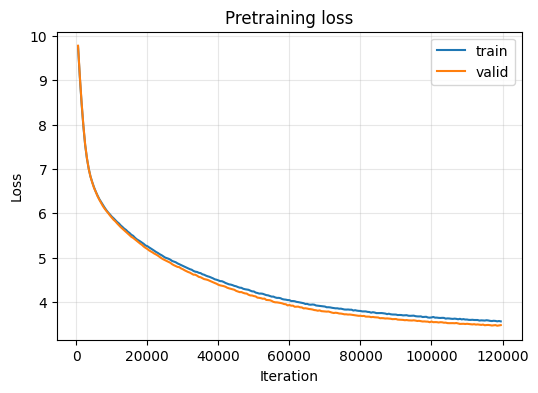

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

eval_every = eval_iters  # e.g., 500

# Convert each tensor to float on CPU
train_loss_np = [float(t.cpu()) for t in train_loss_list]
valid_loss_np = [float(t.cpu()) for t in validation_loss_list]

steps = np.arange(1, len(train_loss_np) + 1) * eval_every

plt.figure(figsize=(6,4))
plt.plot(steps, train_loss_np, label='train')
plt.plot(steps, valid_loss_np, label='valid')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Pretraining loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [ ]:
import torch

ckpt_path = "best_model_params.pt"  # you saved this in the loop
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(42380, 384)
    (wpe): Embedding(128, 384)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=True)
          (c_proj): Linear(in_features=384, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=42380, bias=False)
)

### 1.14 Evaluation on HoC Part 1 (the Hallmarks of Cancers corpus) classification dataset

In [ ]:
# ===== Zero-shot HoC evaluation for your PRE-TRAINED GPT (with cue + EOS delay) =====
# Uses your existing GPT / GPTConfig and loads ckpt_path="best_model_params.pt"

# installs
!pip -q install sacremoses==0.0.53 scikit-learn==1.5.1

import os, math, difflib, tempfile, subprocess
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support
from sacremoses import MosesDetokenizer

# ---------- paths ----------
HOC_DIR     = "/content/hoc"                 # train.tsv / valid.tsv / test.tsv live here
BPE_CODES   = "/content/bpecodes"            # from BioGPT
DICT_TXT    = "/content/dict.txt"            # from BioGPT
FASTBPE_BIN = "/content/fastBPE/fast"        # compiled earlier
ckpt_path   = ckpt_path if 'ckpt_path' in globals() else "best_model_params.pt"

os.makedirs(HOC_DIR, exist_ok=True)

# ---------- ensure fastBPE + BioGPT codes/dict ----------
if not os.path.exists(FASTBPE_BIN):
    !git clone -q https://github.com/glample/fastBPE.git /content/fastBPE
    %cd /content/fastBPE
    !g++ -std=c++11 -O3 -pthread fastBPE/main.cc -IfastBPE -o fast
    %cd /content
if not os.path.exists(BPE_CODES):
    !wget -q -O /content/bpecodes https://raw.githubusercontent.com/microsoft/BioGPT/main/data/BioGPT/bpecodes
if not os.path.exists(DICT_TXT):
    !wget -q -O /content/dict.txt  https://raw.githubusercontent.com/microsoft/BioGPT/main/data/BioGPT/dict.txt

# ---------- vocab maps ----------
token2id, id2token = {}, {}
with open(DICT_TXT, encoding="utf-8") as f:
    for i, line in enumerate(f):
        tok = line.split()[0]
        token2id[tok] = i
        id2token[i] = tok

eos_id = token2id.get("</s>", 0)
pad_id = eos_id  # safe pad; loss is masked anyway

# ---------- BPE helpers ----------
def bpe_encode_lines(lines, shard_size=2000, desc="BPE"):
    if len(lines) == 0:
        return []
    out = []
    with tempfile.TemporaryDirectory() as td:
        for start in tqdm(range(0, len(lines), shard_size), desc=f"{desc} ({len(lines)} lines)", leave=False):
            chunk = lines[start:start+shard_size]
            src = os.path.join(td, f"src_{start}.txt")
            dst = os.path.join(td, f"dst_{start}.bpe")
            with open(src, "w", encoding="utf-8") as w:
                for s in chunk: w.write((s or "").strip() + "\n")
            subprocess.check_call([FASTBPE_BIN, "applybpe", dst, src, BPE_CODES])
            with open(dst, "r", encoding="utf-8") as r:
                for line in r:
                    out.append(line.strip().split())
    return out

def tokens_to_ids(bpe_tokens):
    ids = []
    for t in bpe_tokens:
        ids.append(token2id.get(t, pad_id))
    return ids, 0

def bpe_decode_tokens(bpe_tokens):
    s = ' '.join(bpe_tokens).replace('@@ ', '')
    return MosesDetokenizer(lang='en').detokenize(s.split())

# ---------- load HoC test ----------
def load_hoc_tsv(path):
    df = pd.read_csv(path, sep="\t", header=None, dtype=str).fillna("")
    assert df.shape[1] == 2, f"{path} must have 2 columns"
    avg0, avg1 = df[0].astype(str).str.len().mean(), df[1].astype(str).str.len().mean()
    df.columns = ["text","label"] if avg0 > avg1 else ["label","text"]
    return df

test_path = os.path.join(HOC_DIR, "test.tsv")
assert os.path.exists(test_path), f"Missing {test_path}"
test_df = load_hoc_tsv(test_path)
print("Test size:", len(test_df))

# ---------- the 10 Hallmarks (no 'empty') ----------
HALLMARKS = [
    "activating invasion and metastasis",
    "avoiding immune destruction",
    "cellular energetics",
    "enabling replicative immortality",
    "evading growth suppressors",
    "genomic instability and mutation",
    "inducing angiogenesis",
    "resisting cell death",
    "sustaining proliferative signaling",
    "tumor promoting inflammation",
]

def split_labels(s: str):
    s = (s or "").strip()
    if not s: return []
    for sep in [",",";","|"]:
        if sep in s:
            return [p.strip() for p in s.split(sep) if p.strip()]
    return [s]

def normalize_labels(labs):
    keep, low = [], [L.lower() for L in HALLMARKS]
    for x in labs:
        xl = x.lower().strip()
        if xl in low:
            keep.append(HALLMARKS[low.index(xl)])
        else:
            best = difflib.get_close_matches(xl, low, n=1, cutoff=0.7)
            if best:
                keep.append(HALLMARKS[low.index(best[0])])
    return sorted(dict.fromkeys(keep))

# ---------- Build allowed-token mask (labels + separators + </s>) & first-step forbids ----------
def build_allowed_mask_and_first_forbid(vocab_size, device):
    allowed = set()
    sep_ids = set()
    # Hallmark tokens (all tokens that appear in these strings)
    for bpe in bpe_encode_lines(HALLMARKS, desc="BPE hallmarks"):
        ids, _ = tokens_to_ids(bpe); allowed.update(ids)
    # Separators; we also record their token ids to block at the first step
    SEPS = [", ", ",", "; ", ";", "|", " and "]
    for sep in SEPS:
        bpe = bpe_encode_lines([sep], desc="BPE seps")[0]
        ids, _ = tokens_to_ids(bpe)
        allowed.update(ids)
        sep_ids.update(ids)
    allowed.add(eos_id)

    mask = torch.full((vocab_size,), float('-inf'), device=device)
    mask[list(allowed)] = 0.0
    first_forbid = torch.zeros((vocab_size,), dtype=torch.bool, device=device)
    first_forbid[list(sep_ids)] = True
    first_forbid[eos_id] = True  # never allow EOS as the first generated token
    return mask, first_forbid

device = "cuda" if torch.cuda.is_available() else "cpu"
ALLOWED_MASK, FIRST_STEP_FORBID = build_allowed_mask_and_first_forbid(len(token2id), device)

# ---------- Build contexts (text </s> + textual cue) ----------
PROMPT_TEXT = " hallmarks of cancer:"  # small cue after abstract
PROMPT_BPE  = bpe_encode_lines([PROMPT_TEXT], desc="BPE prompt")[0]
PROMPT_IDS, _ = tokens_to_ids(PROMPT_BPE)

def make_context_with_prompt(df):
    texts = df["text"].astype(str).tolist()
    bpes  = bpe_encode_lines(texts, desc="BPE test ctx")
    ctx = []
    for bpe in bpes:
        ids, _ = tokens_to_ids(bpe)
        ctx.append(np.array(ids + [eos_id] + PROMPT_IDS, dtype=np.int64))
    return ctx

def pad_batch(seqs):
    L = max(len(s) for s in seqs)
    out = np.full((len(seqs), L), pad_id, dtype=np.int64)
    for i, s in enumerate(seqs):
        out[i, :len(s)] = s
    return torch.from_numpy(out)

def ids_to_tokens(ids):
    return [id2token.get(int(i), "<unk>") for i in ids]

def to_canonical(pred_chunk: str):
    s = (pred_chunk or "").strip().lower()
    low = [L.lower() for L in HALLMARKS]
    if s in low: return HALLMARKS[low.index(s)]
    best = difflib.get_close_matches(s, low, n=1, cutoff=0.7)
    return HALLMARKS[low.index(best[0])] if best else None

# ---------- Require your GPT & GPTConfig from pretraining ----------
assert 'GPT' in globals(), "Please define your GPT class (same as pretraining) before running this cell."
assert 'GPTConfig' in globals(), "Please ensure GPTConfig is defined."

cfg = GPTConfig(
    vocab_size=len(token2id),
    block_size=(config.block_size if 'config' in globals() else 128),
    n_layer=(config.n_layer if 'config' in globals() else 6),
    n_head=(config.n_head if 'config' in globals() else 6),
    n_embd=(config.n_embd if 'config' in globals() else 384),
    dropout=(config.dropout if 'config' in globals() else 0.1),
    bias=(config.bias if 'config' in globals() else True),
)
base = GPT(cfg).to(device)

# safe WPE resize when loading the checkpoint
def load_with_wpe_resize(model, ckpt_path):
    sd = torch.load(ckpt_path, map_location="cpu")
    key = "transformer.wpe.weight"
    if key in sd:
        old = sd[key]
        new_w = model.transformer.wpe.weight
        new_len = new_w.shape[0]
        if old.shape[0] != new_len:
            new = new_w.data.clone()
            n = min(new_len, old.shape[0])
            new[:n] = old[:n]
            if new_len > n:
                torch.nn.init.normal_(new[n:], mean=0.0, std=0.02)
            sd[key] = new
    missing, unexpected = base.load_state_dict(sd, strict=False)
    if missing or unexpected:
        print("Missing keys:", missing)
    print("Loaded PRETRAINED checkpoint:", ckpt_path)

assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"
load_with_wpe_resize(base, ckpt_path)
base.eval()

# ---------- Constrained greedy decode with cue + EOS delay ----------
@torch.no_grad()
def gpt_generate_with_cue(model, idx, allowed_mask, first_step_forbid,
                          max_new_tokens=24, min_new_before_eos=2, eos_penalty=-2.0, temperature=0.0):
    """
    - Restrict vocabulary with `allowed_mask`
    - For the very first generated token, forbid separators + EOS
    - For the first `min_new_before_eos` tokens, disallow EOS entirely
    - After that, add a small penalty to EOS (so it doesn't end too early)
    """
    out = idx.clone()
    B = out.size(0)
    finished = torch.zeros(B, dtype=torch.bool, device=out.device)
    steps = 0
    for _ in range(max_new_tokens):
        ctx = out[:, -model.config.block_size:]
        logits, _ = model(ctx)                 # (B,1,V)
        logits = logits[:, -1, :]              # (B,V)

        # restrict to label vocab
        logits = logits + allowed_mask

        # first token: block separators + EOS
        if steps == 0:
            logits[:, first_step_forbid] = -1e9

        # delay EOS for a couple steps, then mildly penalize
        if steps < min_new_before_eos:
            logits[:, eos_id] = -1e9
        else:
            logits[:, eos_id] += eos_penalty

        # pick next
        if temperature <= 0:
            next_id = torch.argmax(logits, dim=-1)
        else:
            probs = F.softmax(logits / temperature, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).squeeze(1)

        next_id = next_id.masked_fill(finished, eos_id)
        out = torch.cat([out, next_id.unsqueeze(1)], dim=1)
        finished |= (next_id == eos_id)
        steps += 1
        if bool(finished.all()):
            break
    return out[:, idx.size(1):]

@torch.no_grad()
def predict_labels_for_batch_generative(xb):
    gens = gpt_generate_with_cue(
        base, xb, allowed_mask=ALLOWED_MASK, first_step_forbid=FIRST_STEP_FORBID,
        max_new_tokens=24, min_new_before_eos=2, eos_penalty=-2.0, temperature=0.0
    )
    preds = []
    for g in gens:
        toks = ids_to_tokens(g.detach().cpu().numpy())
        toks = toks[: toks.index("</s>")] if "</s>" in toks else toks
        label_str = bpe_decode_tokens(toks).strip().lower()

        parts = []
        for sep in [",",";","|"]:
            if sep in label_str:
                parts = [p.strip() for p in label_str.split(sep) if p.strip()]
                break
        if not parts:
            parts = [label_str] if label_str else []

        mapped = []
        for p in parts:
            can = to_canonical(p)
            if can and can not in mapped:
                mapped.append(can)
        preds.append(mapped)  # may be []
    return preds

# ---------- Run decoding on TEST ----------
ctx_test = make_context_with_prompt(test_df)
preds_all = []
B = 32
for i in tqdm(range(0, len(ctx_test), B), desc="Decoding (pretrain+cue, test)"):
    xb = pad_batch(ctx_test[i:i+B]).to(device)
    preds_all.extend(predict_labels_for_batch_generative(xb))

# ---------- Ground truth & metrics (10 hallmarks only) ----------
y_true = [ normalize_labels(split_labels(s)) for s in test_df["label"].astype(str).tolist() ]
LABELS = HALLMARKS
LIDX = {l:i for i,l in enumerate(LABELS)}
def binarize(labs):
    v = [0]*len(LABELS)
    for l in labs:
        if l in LIDX: v[LIDX[l]] = 1
    return v

Y_true = np.array([binarize(l) for l in y_true], dtype=np.int64)
Y_pred = np.array([binarize(l) for l in preds_all], dtype=np.int64)

micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(Y_true, Y_pred, average='micro', zero_division=0)
macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(Y_true, Y_pred, average='macro', zero_division=0)

print(f"\n[PRETRAIN+cue] HALLMARKS-ONLY  Micro  P/R/F1: {micro_p:.4f} / {micro_r:.4f} / {micro_f1:.4f}")
print(  f"[PRETRAIN+cue] HALLMARKS-ONLY  Macro  P/R/F1: {macro_p:.4f} / {macro_r:.4f} / {macro_f1:.4f}")

perclass = precision_recall_fscore_support(Y_true, Y_pred, average=None, zero_division=0)
per_df_pre = pd.DataFrame({
    "label": LABELS,
    "precision": perclass[0],
    "recall":    perclass[1],
    "f1":        perclass[2],
    "support":   perclass[3],
}).sort_values("label")

print("\nPer-class results (PRETRAIN+cue, 10 hallmarks):")
print(per_df_pre.to_string(index=False))

per_df_pre.to_csv("hoc_test_results_pretrain_cue.csv", index=False)
print("Saved: hoc_test_results_pretrain_cue.csv")

# (optional) exclude empty-label rows from eval:
# mask = (Y_true.sum(axis=1) > 0)
# ... recompute scores on Y_true[mask], Y_pred[mask]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 120.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.
Test size: 4947


BPE hallmarks (10 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE prompt (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

Loaded PRETRAINED checkpoint: best_model_params.pt


BPE test ctx (4947 lines):   0%|          | 0/3 [00:00<?, ?it/s]

Decoding (pretrain+cue, test):   0%|          | 0/155 [00:00<?, ?it/s]


[PRETRAIN+cue] HALLMARKS-ONLY  Micro  P/R/F1: 0.0895 / 0.0707 / 0.0790
[PRETRAIN+cue] HALLMARKS-ONLY  Macro  P/R/F1: 0.0700 / 0.0970 / 0.0340

Per-class results (PRETRAIN+cue, 10 hallmarks):
                             label  precision   recall       f1  support
activating invasion and metastasis   0.000000 0.000000 0.000000      223
       avoiding immune destruction   0.000000 0.000000 0.000000       80
               cellular energetics   0.093750 0.040000 0.056075       75
  enabling replicative immortality   0.000000 0.000000 0.000000      103
        evading growth suppressors   0.000000 0.000000 0.000000      122
  genomic instability and mutation   0.333333 0.003774 0.007463      265
             inducing angiogenesis   0.074627 0.818182 0.136778      110
              resisting cell death   0.198718 0.108014 0.139955      287
sustaining proliferative signaling   0.000000 0.000000 0.000000      326
      tumor promoting inflammation   0.000000 0.000000 0.000000      178
Saved

### 1.15 Evaluation on HoC Part 2 (the Hallmarks of Cancers corpus) classification dataset

In [ ]:
# === Show 10 "questions" (abstract + prompt) and the model's answers (pretrained+cue) ===
import os, difflib, numpy as np, pandas as pd, torch, torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support

# ---- Assumptions / fallbacks ----
HOC_DIR   = globals().get("HOC_DIR", "/content/hoc")
ckpt_path = globals().get("ckpt_path", "best_model_params.pt")
device    = "cuda" if torch.cuda.is_available() else "cpu"

# Hallmarks (10 classes, no "empty")
HALLMARKS = [
    "activating invasion and metastasis",
    "avoiding immune destruction",
    "cellular energetics",
    "enabling replicative immortality",
    "evading growth suppressors",
    "genomic instability and mutation",
    "inducing angiogenesis",
    "resisting cell death",
    "sustaining proliferative signaling",
    "tumor promoting inflammation",
]

# ---------- Helper fallbacks if not defined earlier ----------
def _need(name): return name not in globals()

# TSV loader
if _need("load_hoc_tsv"):
    def load_hoc_tsv(path):
        df = pd.read_csv(path, sep="\t", header=None, dtype=str).fillna("")
        assert df.shape[1] == 2, f"{path} must have 2 columns"
        avg0, avg1 = df[0].astype(str).str.len().mean(), df[1].astype(str).str.len().mean()
        df.columns = ["text","label"] if avg0 > avg1 else ["label","text"]
        return df

# If test_df not in memory, load it
if "test_df" not in globals():
    test_df = load_hoc_tsv(os.path.join(HOC_DIR, "test.tsv"))

# Simple label split/normalization utilities
def split_labels(s: str):
    s = (s or "").strip()
    if not s: return []
    for sep in [",",";","|"]:
        if sep in s:
            return [p.strip() for p in s.split(sep) if p.strip()]
    return [s]

def normalize_labels(labs):
    keep, low = [], [L.lower() for L in HALLMARKS]
    for x in labs:
        xl = x.lower().strip()
        if xl in low:
            keep.append(HALLMARKS[low.index(xl)])
        else:
            best = difflib.get_close_matches(xl, low, n=1, cutoff=0.7)
            if best:
                keep.append(HALLMARKS[low.index(best[0])])
    # de-dup & stable order
    seen, out = set(), []
    for k in keep:
        if k not in seen:
            seen.add(k); out.append(k)
    return out

# BPE helpers (must exist: token2id, id2token, bpe_encode_lines, tokens_to_ids, bpe_decode_tokens, eos_id, pad_id)
for req in ["token2id","id2token","bpe_encode_lines","tokens_to_ids","bpe_decode_tokens","eos_id","pad_id"]:
    assert req in globals(), f"Missing `{req}` — run the setup cell that defines dict/bpecodes and BPE helpers."

# Build allowed-token mask & first-step forbids if not present
if _need("ALLOWED_MASK") or _need("FIRST_STEP_FORBID"):
    def build_allowed_mask_and_first_forbid(vocab_size, device):
        allowed = set(); sep_ids = set()
        # all tokens that appear in hallmark strings
        for bpe in bpe_encode_lines(HALLMARKS, desc="BPE hallmarks"):
            ids, _ = tokens_to_ids(bpe); allowed.update(ids)
        # separators (also block them on very first generated step)
        SEPS = [", ", ",", "; ", ";", "|", " and "]
        for sep in SEPS:
            bpe = bpe_encode_lines([sep], desc="BPE seps")[0]
            ids, _ = tokens_to_ids(bpe); allowed.update(ids); sep_ids.update(ids)
        allowed.add(eos_id)
        mask = torch.full((vocab_size,), float('-inf'), device=device)
        mask[list(allowed)] = 0.0
        first_forbid = torch.zeros((vocab_size,), dtype=torch.bool, device=device)
        first_forbid[list(sep_ids)] = True
        first_forbid[eos_id] = True
        return mask, first_forbid
    ALLOWED_MASK, FIRST_STEP_FORBID = build_allowed_mask_and_first_forbid(len(token2id), device)

# Prompt (the "question" cue)
PROMPT_TEXT = " hallmarks of cancer:"
PROMPT_BPE  = bpe_encode_lines([PROMPT_TEXT], desc="BPE prompt")[0]
PROMPT_IDS, _ = tokens_to_ids(PROMPT_BPE)

# Build contexts with prompt
def make_context_with_prompt(rows):
    bpes = bpe_encode_lines(rows["text"].astype(str).tolist(), desc="BPE ctx (sample)")
    ctx = []
    for bpe in bpes:
        ids, _ = tokens_to_ids(bpe)
        ctx.append(np.array(ids + [eos_id] + PROMPT_IDS, dtype=np.int64))
    return ctx

def pad_batch(seqs):
    L = max(len(s) for s in seqs)
    out = np.full((len(seqs), L), pad_id, dtype=np.int64)
    for i, s in enumerate(seqs):
        out[i, :len(s)] = s
    return torch.from_numpy(out)

def ids_to_tokens(ids):
    return [id2token.get(int(i), "<unk>") for i in ids]

def to_canonical(pred_chunk: str):
    s = (pred_chunk or "").strip().lower()
    low = [L.lower() for L in HALLMARKS]
    if s in low: return HALLMARKS[low.index(s)]
    best = difflib.get_close_matches(s, low, n=1, cutoff=0.7)
    return HALLMARKS[low.index(best[0])] if best else None

# If the pretrained model (`base`) isn’t loaded yet, load it
if _need("base"):
    assert 'GPT' in globals() and 'GPTConfig' in globals(), "Define GPT and GPTConfig first (your pretraining classes)."
    assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"
    cfg = GPTConfig(
        vocab_size=len(token2id),
        block_size=(config.block_size if 'config' in globals() else 128),
        n_layer=(config.n_layer if 'config' in globals() else 6),
        n_head=(config.n_head if 'config' in globals() else 6),
        n_embd=(config.n_embd if 'config' in globals() else 384),
        dropout=(config.dropout if 'config' in globals() else 0.1),
        bias=(config.bias if 'config' in globals() else True),
    )
    base = GPT(cfg).to(device)
    # safe WPE resize
    def load_with_wpe_resize(model, path):
        sd = torch.load(path, map_location="cpu")
        key = "transformer.wpe.weight"
        if key in sd:
            old = sd[key]
            new_w = model.transformer.wpe.weight
            new_len = new_w.shape[0]
            if old.shape[0] != new_len:
                new = new_w.data.clone()
                n = min(new_len, old.shape[0])
                new[:n] = old[:n]
                if new_len > n:
                    torch.nn.init.normal_(new[n:], mean=0.0, std=0.02)
                sd[key] = new
        model.load_state_dict(sd, strict=False)
    load_with_wpe_resize(base, ckpt_path)
    base.eval()

# Constrained generation with cue + EOS delay (define if missing)
if _need("gpt_generate_with_cue"):
    @torch.no_grad()
    def gpt_generate_with_cue(model, idx, allowed_mask, first_step_forbid,
                              max_new_tokens=24, min_new_before_eos=2, eos_penalty=-2.0, temperature=0.0):
        out = idx.clone()
        B = out.size(0)
        finished = torch.zeros(B, dtype=torch.bool, device=out.device)
        steps = 0
        for _ in range(max_new_tokens):
            ctx = out[:, -model.config.block_size:]
            logits, _ = model(ctx)           # (B,1,V)
            logits = logits[:, -1, :]        # (B,V)
            logits = logits + allowed_mask    # restrict vocab
            if steps == 0:
                logits[:, first_step_forbid] = -1e9
            if steps < min_new_before_eos:
                logits[:, eos_id] = -1e9
            else:
                logits[:, eos_id] += eos_penalty
            if temperature <= 0:
                next_id = torch.argmax(logits, dim=-1)
            else:
                probs = F.softmax(logits / temperature, dim=-1)
                next_id = torch.multinomial(probs, num_samples=1).squeeze(1)
            next_id = next_id.masked_fill(finished, eos_id)
            out = torch.cat([out, next_id.unsqueeze(1)], dim=1)
            finished |= (next_id == eos_id)
            steps += 1
            if bool(finished.all()):
                break
        return out[:, idx.size(1):]

# ---------- Sample 10 and print Q&A ----------
SAMPLE_N = 10
sample = test_df.sample(n=min(SAMPLE_N, len(test_df)), random_state=42).reset_index(drop=True)

# prepare contexts
ctx = make_context_with_prompt(sample)
B = 10  # single batch is fine here
xb = pad_batch(ctx).to(device)

# generate
gens = gpt_generate_with_cue(
    base, xb, allowed_mask=ALLOWED_MASK, first_step_forbid=FIRST_STEP_FORBID,
    max_new_tokens=24, min_new_before_eos=2, eos_penalty=-2.0, temperature=0.0
)

# decode + print
for i, g in enumerate(gens):
    text = sample.loc[i, "text"]
    gold = normalize_labels(split_labels(sample.loc[i, "label"]))

    toks = ids_to_tokens(g.detach().cpu().numpy())
    toks = toks[: toks.index("</s>")] if "</s>" in toks else toks
    raw = ' '.join(toks).replace('@@ ', '').strip().lower()

    # split raw into parts and map to canonical labels
    parts = []
    for sep in [",",";","|"]:
        if sep in raw:
            parts = [p.strip() for p in raw.split(sep) if p.strip()]
            break
    if not parts:
        parts = [raw] if raw else []
    pred = []
    for p in parts:
        can = to_canonical(p)
        if can and can not in pred:
            pred.append(can)

    print(f"\n=== Example {i+1} ===")
    print("QUESTION:")
    print("Abstract:", (text.replace("\n"," ")[:350] + ("..." if len(text) > 350 else "")))
    print("Prompt:  hallmarks of cancer:")
    print("GOLD:   ", gold if gold else "[]")
    print("ANSWER: ", pred if pred else "[]")
    print("Raw gen:", raw if raw else "<empty>")


BPE prompt (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE ctx (sample) (10 lines):   0%|          | 0/1 [00:00<?, ?it/s]


=== Example 1 ===
QUESTION:
Abstract: Ovarian cancer-related angiogenesis is a complex process orchestrated by many positive and negative regulators .
Prompt:  hallmarks of cancer:
GOLD:    []
ANSWER:  ['inducing angiogenesis']
Raw gen: angiogenesis and angiogenesis , and angiogenesis , and angiogenesis , and angiogenesis , and angiogenesis , and angiogenesis , and angiogenesis , and angiogenesis

=== Example 2 ===
QUESTION:
Abstract: In 81B-Fb cells , downregulation of EGFR , which is mediated by increased ubiquitination , and activation of downstream protein kinase B ( Akt ) , glycogen synthase kinase-beta ( GSK-3beta ) signalling and upregulation of snail expression were observed compared with UMSCC81B cells .
Prompt:  hallmarks of cancer:
GOLD:    ['sustaining proliferative signaling']
ANSWER:  []
Raw gen: cellular and cellular , cellular , and cellular , cellular , and cellular , cellular , and cellular , and cellular , cellular ,

=== Example 3 ===
QUESTION:
Abstract: Microcell 

## Part 2: Finetuning

### 2.1 Setup: paths + installs

In [ ]:
# --- Setup: paths + installs (run once) ---
!pip -q install sacremoses==0.0.53 scikit-learn==1.5.1

import os, subprocess, json, math, random, difflib, tempfile, shutil
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR
from sacremoses import MosesDetokenizer
from tqdm.auto import tqdm  # <-- used in BPE w/ progress

# ---- paths ----
HOC_DIR   = "/content/hoc"                # << put your train/valid/test.tsv here
BPE_CODES = "/content/bpecodes"           # from your pre-training cell
DICT_TXT  = "/content/dict.txt"           # from your pre-training cell
FASTBPE   = "/content/fastBPE/fast"       # compiled earlier in your notebook

os.makedirs(HOC_DIR, exist_ok=True)

# Ensure fastBPE exists (rebuild if needed)
if not os.path.exists(FASTBPE):
    !git clone -q https://github.com/glample/fastBPE.git /content/fastBPE
    %cd /content/fastBPE
    !g++ -std=c++11 -O3 -pthread fastBPE/main.cc -IfastBPE -o fast
    %cd /content

# ---- load BioGPT dictionary ----
token2id = {}
id2token = {}
with open(DICT_TXT, encoding="utf-8") as f:
    for i, line in enumerate(f):
        tok = line.split()[0]
        token2id[tok] = i
        id2token[i] = tok

# pick special ids
eos_id = token2id.get("</s>", 0)
pad_id = eos_id  # safe padding with eos for inputs; we mask loss anyway

# ---- BPE encode/decode helpers (fastBPE uses '@@' continuation) ----
def bpe_encode_lines(lines, shard_size=2000, desc="BPE"):
    """
    Progress-enabled BPE encoding using fastBPE, processing in shards.
    Returns: list[list[str]] (BPE tokens per line)
    """
    if len(lines) == 0:
        return []
    out_tokens = []
    with tempfile.TemporaryDirectory() as td:
        for start in tqdm(range(0, len(lines), shard_size), desc=f"{desc} ({len(lines)} lines)", leave=False):
            chunk = lines[start:start+shard_size]
            src = os.path.join(td, f"src_{start}.txt")
            dst = os.path.join(td, f"dst_{start}.bpe")
            with open(src, "w", encoding="utf-8") as f:
                for s in chunk:
                    f.write((s or "").strip() + "\n")
            subprocess.check_call([FASTBPE, "applybpe", dst, src, BPE_CODES])
            with open(dst, "r", encoding="utf-8") as f:
                for line in f:
                    out_tokens.append(line.strip().split())
    return out_tokens

def bpe_decode_tokens(bpe_tokens):
    """Merge '@@' continuations and detokenize to plain text (for label decoding)."""
    s = ' '.join(bpe_tokens).replace('@@ ', '')
    md = MosesDetokenizer(lang='en')
    return md.detokenize(s.split())

def tokens_to_ids(bpe_tokens):
    ids = []
    oov = 0
    for t in bpe_tokens:
        if t in token2id:
            ids.append(token2id[t])
        else:
            ids.append(pad_id)  # unlikely, but safe fallback
            oov += 1
    return ids, oov


### 2.2 Load HoC dataset and map targets to labels

In [ ]:
# --- Load HoC TSVs (2 columns, no header). Heuristically figure out which is text vs label. ---
def load_hoc_tsv(path):
    df = pd.read_csv(path, sep="\t", header=None, dtype=str).fillna("")
    assert df.shape[1] == 2, f"Expected 2 columns in {path}, got {df.shape}"
    avg0, avg1 = df[0].astype(str).str.len().mean(), df[1].astype(str).str.len().mean()
    if avg0 > avg1:
        df.columns = ["text", "label"]
    else:
        df.columns = ["label", "text"]
    return df

train_df = load_hoc_tsv(f"{HOC_DIR}/train.tsv")
valid_df = load_hoc_tsv(f"{HOC_DIR}/valid.tsv")
test_df  = load_hoc_tsv(f"{HOC_DIR}/test.tsv")

print("Splits:", len(train_df), len(valid_df), len(test_df))

# --- Hallmarks (10 classes; we ignore 'empty' for training and for reporting) ---
HALLMARKS = [
    "activating invasion and metastasis",
    "avoiding immune destruction",
    "cellular energetics",
    "enabling replicative immortality",
    "evading growth suppressors",
    "genomic instability and mutation",
    "inducing angiogenesis",
    "resisting cell death",
    "sustaining proliferative signaling",
    "tumor promoting inflammation",
]

def split_labels(s: str):
    s = (s or "").strip()
    if not s: return []
    for sep in [",", ";", "|"]:
        if sep in s:
            return [p.strip() for p in s.split(sep) if p.strip()]
    return [s]

def normalize_labels(labs):
    """Map raw labels (including fuzzy matches) to the 10 hallmarks; drop 'empty'."""
    keep = []
    low = [L.lower() for L in HALLMARKS]
    for x in labs:
        x_low = x.lower().strip()
        if x_low in low:
            keep.append(HALLMARKS[low.index(x_low)])
        else:
            best = difflib.get_close_matches(x_low, low, n=1, cutoff=0.7)
            if best:
                keep.append(HALLMARKS[low.index(best[0])])
    # dedupe & sort for deterministic target text
    return sorted(list(dict.fromkeys(keep)))

def labels_to_target_text(labs):
    labs = normalize_labels(labs)
    if len(labs) == 0:
        return None  # -> drop from training if empty-only
    return ", ".join(labs)


Splits: 9972 4947 4947


### 2.3 Redefine GPT architecture for full finetuning

In [ ]:
# --- Your GPT modules (same as in your pretraining code) ---
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))
    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None,
                                               dropout_p=self.attn_dropout.p if self.training else 0.0,
                                               is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

from dataclasses import dataclass
@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # weight tying
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        B, T = idx.size()
        assert T <= self.config.block_size
        pos = torch.arange(0, T, dtype=torch.long, device=device)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        if targets is not None:
            logits = self.lm_head(x)               # (B,T,V)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-1
            )
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])   # (B,1,V)
            return logits, None



### 2.4 Define Add SoftPrompt embeddings to input embeddings

In [ ]:
class GPTWithSoftPrompt(nn.Module):
    def __init__(self, base_gpt: GPT, prompt_len=1):
        super().__init__()
        self.config = base_gpt.config
        self.transformer = base_gpt.transformer
        self.lm_head = base_gpt.lm_head
        C = self.config.n_embd
        self.soft_prompt = nn.Parameter(torch.zeros(1, prompt_len, C))
        nn.init.normal_(self.soft_prompt, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        device = idx.device

        # token + pos
        tok_emb = self.transformer.wte(idx)                              # (B,T,C)
        pos = torch.arange(0, T, dtype=torch.long, device=device)
        pos_emb = self.transformer.wpe(pos)                              # (T,C)
        x_tokens = tok_emb + pos_emb

        # prepend soft prompt
        soft = self.soft_prompt.expand(B, -1, -1)                        # (B,P,C)
        x = torch.cat([soft, x_tokens], dim=1)                           # (B,P+T,C)

        x = self.transformer.drop(x)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)                                         # (B,P+T,V)

        if targets is None:
            # return next-token logits at last (standard for generation)
            return logits[:, -1, :], None

        # ----- FIX: next-token loss with soft-prompt padding -----
        P = soft.size(1)
        pad_ignore = torch.full((B, P), -1, dtype=targets.dtype, device=device)  # ignore for soft prompt
        full_targets = torch.cat([pad_ignore, targets], dim=1)                    # (B,P+T)

        # shift for next-token prediction
        logits_lm  = logits[:, :-1, :].contiguous()                               # predict next token
        targets_lm = full_targets[:, 1:].contiguous()

        loss = F.cross_entropy(
            logits_lm.view(-1, logits_lm.size(-1)),
            targets_lm.view(-1),
            ignore_index=-1
        )
        return logits, loss


### 2.5 Instantiate pre-training weights

In [ ]:
# --- Instantiate & (optionally) load your pretraining weights ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# Use your pretrain block_size (128 in your earlier run). If different, the loader below can resize wpe.
BLOCK_SIZE = 128  # set to 128 if that was your pretrain; otherwise set to your pretrain context length

config = GPTConfig(
    vocab_size=len(token2id),
    block_size=BLOCK_SIZE,
    n_layer=6, n_head=6, n_embd=384,
    dropout=0.1, bias=True
)
base_gpt = GPT(config)

def load_with_wpe_resize(model, ckpt_path):
    sd = torch.load(ckpt_path, map_location="cpu")
    key = "transformer.wpe.weight"
    if key in sd:
        old = sd[key]
        new_len = model.transformer.wpe.weight.shape[0]
        if old.shape[0] != new_len:
            # copy existing, init the rest
            new = model.transformer.wpe.weight.data.clone()
            n = min(new_len, old.shape[0])
            new[:n] = old[:n]
            if new_len > n:
                nn.init.normal_(new[n:], mean=0.0, std=0.02)
            sd[key] = new
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print("Loaded state dict with resize. Missing:", missing, "Unexpected:", unexpected)

pt_path = "best_model_params.pt"
if os.path.exists(pt_path):
    load_with_wpe_resize(base_gpt, pt_path)
    print("Loaded pretraining weights from:", pt_path)
else:
    print("No pretrain checkpoint found; training soft prompt from scratch on top of random GPT.")

model = GPTWithSoftPrompt(base_gpt, prompt_len=1).to(device)


Loaded state dict with resize. Missing: [] Unexpected: []
Loaded pretraining weights from: best_model_params.pt


### 2.6 Build a mask of token IDs that are allowed during generation

In [ ]:
# --- Constrained token mask (only hallmarks + separators + </s>) ---
def build_allowed_token_mask(vocab_size, device):
    allowed = set()
    # hallmark token ids
    for bpe in bpe_encode_lines(HALLMARKS, desc="BPE hallmarks"):
        ids, _ = tokens_to_ids(bpe)
        allowed.update(ids)
    # separators
    for sep in [", ", ",", "; ", ";", "|", " and "]:
        bpe = bpe_encode_lines([sep], desc="BPE seps")[0]
        ids, _ = tokens_to_ids(bpe)
        allowed.update(ids)
    allowed.add(eos_id)
    mask = torch.full((vocab_size,), float('-inf'), device=device)
    mask[list(allowed)] = 0.0
    return mask

ALLOWED_MASK = build_allowed_token_mask(len(token2id), device)


BPE hallmarks (10 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

BPE seps (1 lines):   0%|          | 0/1 [00:00<?, ?it/s]

### 2.7:

- Define a dataset class that encodes abstracts and labels into token IDs (dropping empty-only rows for training if desired)
- Concatenate them into input/target sequences respecting a block size
- Provide a collate function to pad batches for training.

In [ ]:
# --- Dataset (drops empty-only rows for TRAIN to avoid collapse) ---
class HoCGenDataset(Dataset):
    def __init__(self, df, block_size=256, drop_empty_only=False, name=""):
        self.block_size = block_size
        self.samples = []

        texts = df["text"].astype(str).tolist()
        raw_labels = [split_labels(s) for s in df["label"].astype(str).tolist()]

        # BPE encode texts with progress
        text_bpe = bpe_encode_lines(texts, shard_size=2000, desc=f"BPE {name or 'dataset'}")

        # Pre-encode unique label targets
        targets = []
        for labs in raw_labels:
            tgt = labels_to_target_text(labs)  # None if empty-only
            targets.append(tgt)
        uniq_non_null = sorted(set([t for t in targets if t is not None]))

        label_cache = {}
        if len(uniq_non_null) > 0:
            encoded = bpe_encode_lines(uniq_non_null, shard_size=200, desc=f"BPE labels {name or 'dataset'}")
            for s, bpe in zip(uniq_non_null, encoded):
                ids, _ = tokens_to_ids(bpe)
                label_cache[s] = ids

        # Pack samples
        for bpe, tgt in tqdm(list(zip(text_bpe, targets)), total=len(text_bpe), desc=f"Packing {name or 'dataset'}", leave=False):
            if drop_empty_only and tgt is None:
                continue
            text_ids, _ = tokens_to_ids(bpe)

            if tgt is None:
                label_ids = []
            else:
                label_ids = label_cache[tgt]

            x_ids = text_ids + [eos_id]
            y_ids = (label_ids + [eos_id]) if len(label_ids) > 0 else []

            # respect block size
            max_text = self.block_size - (2 if len(y_ids) > 0 else 1) - len(y_ids)
            if max_text < 1:
                x_ids = x_ids[:max(1, self.block_size // 2)]
            else:
                x_ids = x_ids[:max_text]

            input_ids = x_ids + y_ids
            targets_arr = ([-1] * len(x_ids)) + (y_ids if len(y_ids) > 0 else [])

            self.samples.append((
                np.array(input_ids, dtype=np.int64),
                np.array(targets_arr, dtype=np.int64)
            ))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

def collate(batch):
    L = max(len(x[0]) for x in batch)
    B = len(batch)
    inputs  = np.full((B, L), pad_id, dtype=np.int64)
    targets = np.full((B, L), -1,     dtype=np.int64)
    for i, (inp, tgt) in enumerate(batch):
        n = len(inp)
        inputs[i, :n]  = inp
        targets[i, :n] = tgt
    return torch.from_numpy(inputs), torch.from_numpy(targets)


### 2.8 Create dataloaders for the finetuning dataset

In [ ]:
# --- Datasets/Loaders ---
BATCH_SIZE = 16

# Train: drop empty-only rows (crucial)
train_ds = HoCGenDataset(train_df, block_size=model.config.block_size, drop_empty_only=True,  name="train")
# Valid: drop empty-only too (makes val loss meaningful)
valid_ds = HoCGenDataset(valid_df, block_size=model.config.block_size, drop_empty_only=True,  name="valid")
# Test: keep all rows; we'll evaluate on the 10 hallmarks only later
test_ds  = HoCGenDataset(test_df,  block_size=model.config.block_size, drop_empty_only=False, name="test")

cuda_gen = torch.Generator(device='cuda')  # or set a manual seed if you want

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=collate, drop_last=True,
    generator=cuda_gen,      # <-- key fix
    pin_memory=True, pin_memory_device='cuda'
)

valid_loader = DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate,
    generator=cuda_gen,
    pin_memory=True, pin_memory_device='cuda'
)

test_loader  = DataLoader(
    test_ds,  batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate,
    generator=cuda_gen,
    pin_memory=True, pin_memory_device='cuda'
)

print(f"Train samples (non-empty only): {len(train_ds)}")
print(f"Valid samples (non-empty only): {len(valid_ds)}")
print(f"Test samples  (incl. empty):    {len(test_ds)}")


BPE train (9972 lines):   0%|          | 0/5 [00:00<?, ?it/s]

BPE labels train (68 lines):   0%|          | 0/1 [00:00<?, ?it/s]

Packing train:   0%|          | 0/9972 [00:00<?, ?it/s]

BPE valid (4947 lines):   0%|          | 0/3 [00:00<?, ?it/s]

BPE labels valid (61 lines):   0%|          | 0/1 [00:00<?, ?it/s]

Packing valid:   0%|          | 0/4947 [00:00<?, ?it/s]

BPE test (4947 lines):   0%|          | 0/3 [00:00<?, ?it/s]

BPE labels test (61 lines):   0%|          | 0/1 [00:00<?, ?it/s]

Packing test:   0%|          | 0/4947 [00:00<?, ?it/s]

Train samples (non-empty only): 2953
Valid samples (non-empty only): 1495
Test samples  (incl. empty):    4947


In [ ]:
xb, yb = next(iter(train_loader))
assert (yb != -1).any(), "No supervised label tokens in this batch — are we dropping all rows?"


In [ ]:
xb, yb = xb.to(device), yb.to(device)
with torch.no_grad():
    _, loss = model(xb, yb)
print("Initial loss:", float(loss))


Initial loss: 7.842709064483643


### 2.9

- Feeds the current context into the model (self(ctx)).

- Adds the allowed_mask to the logits so that only permitted token IDs (Hallmarks, separators, </s>) can be chosen; all others get -inf and are impossible to sample.

- Picks the next token greedily (argmax) unless a temperature is set, in which case it samples.

- Forces already finished sequences to emit </s> and stops early when all sequences are finished.

In [ ]:
# --- Constrained, batched decoding method for GPTWithSoftPrompt ---
def constrained_generate_labels(self, idx, allowed_mask, max_new_tokens=24, temperature=0.0):
    """
    Batched decode. At each step, mask logits to the allowed set.
    Returns only generated tail (B, Tgen).
    """
    self.eval()
    B = idx.size(0)
    out = idx.clone()
    finished = torch.zeros(B, dtype=torch.bool, device=idx.device)

    for _ in range(max_new_tokens):
        ctx = out[:, -self.config.block_size:]
        logits, _ = self(ctx)          # (B,V)
        # apply constraint
        logits = logits + allowed_mask
        if temperature <= 0:
            next_id = torch.argmax(logits, dim=-1)  # (B,)
        else:
            probs = F.softmax(logits / temperature, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).squeeze(1)

        next_id = next_id.masked_fill(finished, eos_id)
        out = torch.cat([out, next_id.unsqueeze(1)], dim=1)
        finished |= (next_id == eos_id)
        if bool(finished.all()):
            break
    return out[:, idx.size(1):]

# attach to instance/class
GPTWithSoftPrompt.generate_labels = constrained_generate_labels


### 2.10 Run the finetuning loop

In [ ]:
# --- Optimizer & schedulers (paper: 20k steps, warmup 1k, peak LR 1e-5) ---
max_steps   = 20_000
warmup      = 1_000
peak_lr     = 1e-5
eta_min     = 1e-6

optimizer   = torch.optim.AdamW(model.parameters(), lr=peak_lr, betas=(0.9, 0.95), weight_decay=0.01, eps=1e-9)
sched_warm  = LinearLR(optimizer, total_iters=warmup)
sched_decay = CosineAnnealingLR(optimizer, T_max=max_steps - warmup, eta_min=eta_min)
scheduler   = SequentialLR(optimizer, [sched_warm, sched_decay], milestones=[warmup])

# AMP dtype: bf16 if supported, else fp16; enable GradScaler only if fp16
amp_dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
scaler    = torch.cuda.amp.GradScaler(enabled=(amp_dtype == torch.float16))

def run_eval(loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Valid", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=torch.cuda.is_available()):
                _, loss = model(xb, yb)
            losses.append(loss.item())
    model.train()
    return float(np.mean(losses)) if losses else 0.0

# --- Training loop ---
EVAL_EVERY = 500
BEST_PATH  = "hoc_best.pt"

best_val = float('inf')
global_step = 0
ema_loss = None
pbar = tqdm(total=max_steps, desc="Finetuning (HoC)", leave=True)

model.train()
while global_step < max_steps:
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=torch.cuda.is_available()):
            _, loss = model(xb, yb)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        global_step += 1
        pbar.update(1)

        cur = loss.item()
        ema_loss = cur if ema_loss is None else (0.95 * ema_loss + 0.05 * cur)
        pbar.set_postfix({
            "train_loss": f"{cur:.3f}",
            "ema":        f"{ema_loss:.3f}",
            "best_val":   f"{best_val:.3f}" if best_val < float('inf') else "—",
            "lr":         f"{optimizer.param_groups[0]['lr']:.2e}",
        })

        if global_step % EVAL_EVERY == 0:
            val_loss = run_eval(valid_loader)
            if val_loss < best_val:
                best_val = val_loss
                torch.save(model.state_dict(), BEST_PATH)
            pbar.set_postfix({
                "train_loss": f"{cur:.3f}",
                "ema":        f"{ema_loss:.3f}",
                "best_val":   f"{best_val:.3f}",
                "lr":         f"{optimizer.param_groups[0]['lr']:.2e}",
            })

        if global_step >= max_steps:
            break

pbar.close()

# reload best
if os.path.exists(BEST_PATH):
    model.load_state_dict(torch.load(BEST_PATH, map_location=device))
    print("Loaded best checkpoint:", BEST_PATH, " (val_loss:", f"{best_val:.4f}", ")")


/tmp/ipython-input-1530140707.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=(amp_dtype == torch.float16))


Finetuning (HoC):   0%|          | 0/20000 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Valid:   0%|          | 0/94 [00:00<?, ?it/s]

Loaded best checkpoint: hoc_best.pt  (val_loss: 0.1731 )


### 2.11 Classification evaluation

In [ ]:
# --- Build context-only inputs (text </s>) directly from raw test_df ---
def make_context_only(df):
    texts = df["text"].astype(str).tolist()
    bpes  = bpe_encode_lines(texts, desc="BPE test ctx")
    ctx = []
    for bpe in bpes:
        ids, _ = tokens_to_ids(bpe)
        ctx.append(np.array(ids + [eos_id], dtype=np.int64))
    return ctx

def pad_batch(seqs):
    L = max(len(s) for s in seqs)
    out = np.full((len(seqs), L), pad_id, dtype=np.int64)
    for i, s in enumerate(seqs):
        out[i, :len(s)] = s
    return torch.from_numpy(out)

def ids_to_tokens(ids):
    return [id2token.get(int(i), "<unk>") for i in ids]

def to_canonical(pred_chunk: str):
    s = (pred_chunk or "").strip().lower()
    low = [L.lower() for L in HALLMARKS]
    if s in low:
        return HALLMARKS[low.index(s)]
    best = difflib.get_close_matches(s, low, n=1, cutoff=0.7)
    return HALLMARKS[low.index(best[0])] if best else None

def predict_labels_for_batch(xb):
    """xb: (B, T) context-only input ids (text </s>)."""
    with torch.no_grad():
        gens = model.generate_labels(xb, allowed_mask=ALLOWED_MASK, max_new_tokens=24, temperature=0.0)
    preds = []
    for g in gens:
        toks = ids_to_tokens(g.detach().cpu().numpy())
        # cut at EOS
        toks = toks[: toks.index("</s>")] if "</s>" in toks else toks
        label_str = bpe_decode_tokens(toks).strip().lower()

        # split multi-label guesses
        parts = []
        for sep in [",", ";", "|"]:
            if sep in label_str:
                parts = [p.strip() for p in label_str.split(sep) if p.strip()]
                break
        if not parts:
            parts = [label_str] if label_str else []

        # map to canonical hallmarks (no default to 'empty')
        mapped = []
        for p in parts:
            can = to_canonical(p)
            if can and can not in mapped:
                mapped.append(can)
        preds.append(mapped)  # may be []
    return preds

# --- Run decoding on TEST ---
model.eval()
ctx_test = make_context_only(test_df)

B = 32
preds_all = []
for i in tqdm(range(0, len(ctx_test), B), desc="Decoding (test)"):
    batch_ctx = pad_batch(ctx_test[i:i+B]).to(device)
    preds_all.extend(predict_labels_for_batch(batch_ctx))

# --- Build ground truth (hallmarks only) ---
y_true = [ normalize_labels(split_labels(s)) for s in test_df["label"].astype(str).tolist() ]

# --- Binarize and score (10 hallmarks only) ---
from sklearn.metrics import precision_recall_fscore_support
LABELS = HALLMARKS
LIDX = {l:i for i,l in enumerate(LABELS)}

def binarize(labs):
    v = [0]*len(LABELS)
    for l in labs:
        if l in LIDX:
            v[LIDX[l]] = 1
    return v

Y_true = np.array([binarize(labs) for labs in y_true], dtype=np.int64)
Y_pred = np.array([binarize(labs) for labs in preds_all], dtype=np.int64)

micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(Y_true, Y_pred, average='micro', zero_division=0)
macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(Y_true, Y_pred, average='macro', zero_division=0)

print(f"\nHALLMARKS-ONLY  Micro  P/R/F1: {micro_p:.4f} / {micro_r:.4f} / {micro_f1:.4f}")
print(  f"HALLMARKS-ONLY  Macro  P/R/F1: {macro_p:.4f} / {macro_r:.4f} / {macro_f1:.4f}")

perclass = precision_recall_fscore_support(Y_true, Y_pred, average=None, zero_division=0)
per_df = pd.DataFrame({
    "label": LABELS,
    "precision": perclass[0],
    "recall":    perclass[1],
    "f1":        perclass[2],
    "support":   perclass[3],
}).sort_values("label")

print("\nPer-class results (10 hallmarks):")
print(per_df.to_string(index=False))

per_df.to_csv("hoc_test_results_per_class.csv", index=False)
print("Saved: hoc_test_results_per_class.csv")


BPE test ctx (4947 lines):   0%|          | 0/3 [00:00<?, ?it/s]

Decoding (test):   0%|          | 0/155 [00:00<?, ?it/s]


HALLMARKS-ONLY  Micro  P/R/F1: 0.2680 / 0.7496 / 0.3949
HALLMARKS-ONLY  Macro  P/R/F1: 0.3264 / 0.7579 / 0.4421

Per-class results (10 hallmarks):
                             label  precision   recall       f1  support
activating invasion and metastasis   0.418750 0.901345 0.571835      223
       avoiding immune destruction   0.275132 0.650000 0.386617       80
               cellular energetics   0.398601 0.760000 0.522936       75
  enabling replicative immortality   0.570513 0.864078 0.687259      103
        evading growth suppressors   0.118644 0.745902 0.204724      122
  genomic instability and mutation   0.261220 0.856604 0.400353      265
             inducing angiogenesis   0.288026 0.809091 0.424821      110
              resisting cell death   0.546599 0.756098 0.634503      287
sustaining proliferative signaling   0.168508 0.561350 0.259207      326
      tumor promoting inflammation   0.217786 0.674157 0.329218      178
Saved: hoc_test_results_per_class.csv
